# PES of Hydrogen Molecule With Various IBMQ Noise Model Backends

Are today's real quantum computer are capable of generating nice results as shown by simulated exact quantum backends? We shall find out eventually in this series of notebooks.

In [1]:
# Native Lib
import itertools as it
import json
import time

# External Lib
import qiskit
import numpy as np
import pennylane as qml
from pennylane import numpy as plnp
import matplotlib.pyplot as plt
from qiskit.providers.aer.noise import NoiseModel

# qanything Lib
import qanything.common_functions as cf
import qanything.get_index as getind
import qanything.get_molecule as getmol
import qanything.get_json as getjson

### Load IBM Noise Model Devices

In [2]:
# Start IBMQ
qiskit.IBMQ.load_account()


# # Get a list of backends
# backend_list = []
# for b in provider.backends():
#     backend_list.append(b.name())

# Filtered Backend List
backend_list = ['ibmq_montreal',
                'ibmq_toronto',
                'ibmq_santiago',
                'ibmq_bogota',
                'ibmq_casablanca',
                'ibmq_mumbai',
                'ibmq_lima',
                'ibmq_belem',
                'ibmq_quito',
                'ibmq_guadalupe',
                'ibmq_brooklyn',
                'ibmq_jakarta',
                'ibmq_manila',
                'ibm_hanoi',
                'ibm_lagos',
                'ibm_cairo',
                'ibm_auckland',
                'ibm_perth',
                'ibm_washington']

### Loading Classically Optimised VQE Parameters from Previous Notebooks

In [3]:
# Load Results from Geometry Optimisation Hydrogen
h2_opt_data_filename = 'h2_morse_vqe.json'
h2_opt_data = getjson.load_from_json(h2_opt_data_filename)

# Show Parameters
for i in range(len(h2_opt_data['bond_length'])):
    print("Bond Length: {:.1f}".format(h2_opt_data['bond_length'][i]))
    print("Hartree-Fock Energy:  {:.5f} Hartree".format(h2_opt_data['hf_ref_energy'][i]))
    print("Reference Energy:     {:.5f} Hartree".format(h2_opt_data['fci_ref_energy'][i]))
    print("VQE Converged Energy: {:.5f} Hartree".format(h2_opt_data['vqe_uccsd_energy'][i]))
    print(f"VQE Converged Params: {[round(j,5) for j in h2_opt_data['vqe_params'][i]]}\n")

Loading Data from: h2_morse_vqe.json
Bond Length: 1.0
Hartree-Fock Energy:  -1.06600 Hartree
Reference Energy:     -1.07897 Hartree
VQE Converged Energy: -1.07897 Hartree
VQE Converged Params: [0.0, 0.0, 0.15208, 0.0, 0.0]

Bond Length: 1.2
Hartree-Fock Energy:  -1.11033 Hartree
Reference Energy:     -1.12670 Hartree
VQE Converged Energy: -1.12670 Hartree
VQE Converged Params: [0.0, 0.0, 0.18591, -0.0, 0.0]

Bond Length: 1.4
Hartree-Fock Energy:  -1.11671 Hartree
Reference Energy:     -1.13728 Hartree
VQE Converged Energy: -1.13728 Hartree
VQE Converged Params: [0.0, 0.0, 0.22586, 0.0, 0.0]

Bond Length: 1.6
Hartree-Fock Energy:  -1.10314 Hartree
Reference Energy:     -1.12882 Hartree
VQE Converged Energy: -1.12882 Hartree
VQE Converged Params: [0.0, -0.0, 0.27216, -0.0, 0.0]

Bond Length: 1.8
Hartree-Fock Energy:  -1.07898 Hartree
Reference Energy:     -1.11085 Hartree
VQE Converged Energy: -1.11085 Hartree
VQE Converged Params: [0.0, -0.0, 0.32526, -0.0, 0.0]

Bond Length: 2.0
Hartre

Analysing VQE converged parameters, it is observed that only the third parameter is non-zero. This effectively mean only double excitation rotation quantum gate is the only contributor to the electronic energy. The reason is that the exact ground state has the same spatial symmetry with Hartree-Fock ground state. As the Doubly Excited state as the same spatial symmetry while all other singly excited states have a different symmetry, only Doubled Excited state will contribute to the exact ground state. (See [Szabo](https://www.amazon.com/Modern-Quantum-Chemistry-Introduction-Electronic/dp/0486691861) Pg 63) Therefore, we only need to apply one double excitation rotation gate on our Hartree-Fock state which will reduce the gate depth and quantum noise.

### Applying IBM Noise Models to Quantum Circuit

In [4]:
# Create Hydrogen Molecule
mol_name = 'h2'
mol_full_name = 'hydrogen molecule'

# Get Hamiltonian
mol_symbols, coords, charge, num_elec = getmol.get_molecule(mol_name, h2_opt_data['bond_length'][0])
mol_ham, num_qubits = qml.qchem.molecular_hamiltonian(symbols=mol_symbols, coordinates=coords, name=mol_full_name ,charge=charge)

# Get the Hartree-Fock State
hf = qml.qchem.hf_state(electrons=num_elec, orbitals=num_qubits)

# Prepare the UCCSD Ansatz based on the Disentangled Order
def uccsd_ansatz(params, wires, excitations):
    qml.BasisState(hf, wires=wires)
    for i, excitation in enumerate(excitations):
        if len(excitation) == 4:
            qml.DoubleExcitation(params[i], wires=excitation)
        else:
            qml.SingleExcitation(params[i], wires=excitation)

# We shall remove all single excitation and only consider the double excitation. 
disentangle_order_only_doubles = [[0, 1, 2, 3]] 

# Maximum Number of Shots available on IBMQ
num_shots = 20000

noisy_backend_noisy_morse = []
for i in range(len(backend_list)):
    print(f'\nCurrent Backend: {backend_list[i]}')
    backend = provider.get_backend(backend_list[i])
    noise_model = NoiseModel.from_backend(backend)
    dev = qml.device('qiskit.aer', wires=num_qubits, backend= 'aer_simulator', noise_model=noise_model, shots = num_shots)
    
    # Loop through all bond lengths and get the noisy energy.
    noisy_morse = []
    for j in range(len(h2_opt_data['bond_length'])):

        # Get Hydrogen Molecule Hamiltonian with new bond length
        bond_length = h2_opt_data['bond_length'][j]
        mol_symbols, coords, charge, num_elec = getmol.get_molecule(mol_name, bond_length)
        mol_ham, num_qubits = qml.qchem.molecular_hamiltonian(symbols=mol_symbols, coordinates=coords, name=mol_full_name ,charge=charge)

        # Get only double excitation rotation angle and perform only double excitation 
        params = [h2_opt_data['vqe_params'][j][2]]
        cost_fn = qml.ExpvalCost(uccsd_ansatz, mol_ham, dev, optimize=False)
        noisy_energy = cost_fn(params, excitations=disentangle_order_only_doubles)
        noisy_morse.append(noisy_energy)
        print("Bond Length: %.1f, Noisy Energy: %.5f" %(bond_length, noisy_energy))

    noisy_backend_noisy_morse.append(noisy_morse)


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/pyscf/lib/misc.py:46: H5pyDeprecationWarning: Using default_file_mode other than 'r' is deprecated. Pass the mode to h5py.File() instead.
  h5py.get_config().default_file_mode = 'a'



Current Backend: ibmq_montreal
Bond Length: 1.0, Noisy Energy: -0.92557
Bond Length: 1.2, Noisy Energy: -0.99515
Bond Length: 1.4, Noisy Energy: -1.01829
Bond Length: 1.6, Noisy Energy: -1.01905
Bond Length: 1.8, Noisy Energy: -1.01240
Bond Length: 2.0, Noisy Energy: -0.99938
Bond Length: 2.2, Noisy Energy: -0.98290
Bond Length: 2.4, Noisy Energy: -0.96635
Bond Length: 2.6, Noisy Energy: -0.94690
Bond Length: 2.8, Noisy Energy: -0.93190
Bond Length: 3.0, Noisy Energy: -0.91882
Bond Length: 3.2, Noisy Energy: -0.90549
Bond Length: 3.4, Noisy Energy: -0.89878
Bond Length: 3.6, Noisy Energy: -0.89234
Bond Length: 3.8, Noisy Energy: -0.88583
Bond Length: 4.0, Noisy Energy: -0.88082

Current Backend: ibmq_toronto
Bond Length: 1.0, Noisy Energy: -0.78300
Bond Length: 1.2, Noisy Energy: -0.87209
Bond Length: 1.4, Noisy Energy: -0.90972
Bond Length: 1.6, Noisy Energy: -0.91747
Bond Length: 1.8, Noisy Energy: -0.91993
Bond Length: 2.0, Noisy Energy: -0.90182
Bond Length: 2.2, Noisy Energy: -0.

Bond Length: 1.0, Noisy Energy: 0.23180
Bond Length: 1.2, Noisy Energy: 0.00888
Bond Length: 1.4, Noisy Energy: -0.13337
Bond Length: 1.6, Noisy Energy: -0.23828
Bond Length: 1.8, Noisy Energy: -0.31413
Bond Length: 2.0, Noisy Energy: -0.37150
Bond Length: 2.2, Noisy Energy: -0.41786
Bond Length: 2.4, Noisy Energy: -0.45258
Bond Length: 2.6, Noisy Energy: -0.47465
Bond Length: 2.8, Noisy Energy: -0.49410
Bond Length: 3.0, Noisy Energy: -0.50767
Bond Length: 3.2, Noisy Energy: -0.51502
Bond Length: 3.4, Noisy Energy: -0.52067
Bond Length: 3.6, Noisy Energy: -0.52567
Bond Length: 3.8, Noisy Energy: -0.52625
Bond Length: 4.0, Noisy Energy: -0.53105

Current Backend: ibmq_bogota
Bond Length: 1.0, Noisy Energy: -0.84943
Bond Length: 1.2, Noisy Energy: -0.91637
Bond Length: 1.4, Noisy Energy: -0.94836
Bond Length: 1.6, Noisy Energy: -0.95607
Bond Length: 1.8, Noisy Energy: -0.94641
Bond Length: 2.0, Noisy Energy: -0.93259
Bond Length: 2.2, Noisy Energy: -0.91793
Bond Length: 2.4, Noisy Energ

Bond Length: 1.0, Noisy Energy: -0.88346
Bond Length: 1.2, Noisy Energy: -0.95396
Bond Length: 1.4, Noisy Energy: -0.98545
Bond Length: 1.6, Noisy Energy: -0.99180
Bond Length: 1.8, Noisy Energy: -0.98567
Bond Length: 2.0, Noisy Energy: -0.97163
Bond Length: 2.2, Noisy Energy: -0.95816
Bond Length: 2.4, Noisy Energy: -0.93850
Bond Length: 2.6, Noisy Energy: -0.92266
Bond Length: 2.8, Noisy Energy: -0.90866
Bond Length: 3.0, Noisy Energy: -0.89491
Bond Length: 3.2, Noisy Energy: -0.88198
Bond Length: 3.4, Noisy Energy: -0.87286
Bond Length: 3.6, Noisy Energy: -0.86964
Bond Length: 3.8, Noisy Energy: -0.85937
Bond Length: 4.0, Noisy Energy: -0.85525

Current Backend: ibmq_lima
Bond Length: 1.0, Noisy Energy: -0.94698
Bond Length: 1.2, Noisy Energy: -1.00910
Bond Length: 1.4, Noisy Energy: -1.03173
Bond Length: 1.6, Noisy Energy: -1.03195
Bond Length: 1.8, Noisy Energy: -1.02441
Bond Length: 2.0, Noisy Energy: -1.00797
Bond Length: 2.2, Noisy Energy: -0.98906
Bond Length: 2.4, Noisy Energ

Bond Length: 1.0, Noisy Energy: -0.84050
Bond Length: 1.2, Noisy Energy: -0.91783
Bond Length: 1.4, Noisy Energy: -0.95414
Bond Length: 1.6, Noisy Energy: -0.96902
Bond Length: 1.8, Noisy Energy: -0.96570
Bond Length: 2.0, Noisy Energy: -0.95255
Bond Length: 2.2, Noisy Energy: -0.94052
Bond Length: 2.4, Noisy Energy: -0.92782
Bond Length: 2.6, Noisy Energy: -0.91196
Bond Length: 2.8, Noisy Energy: -0.89595
Bond Length: 3.0, Noisy Energy: -0.88505
Bond Length: 3.2, Noisy Energy: -0.87594
Bond Length: 3.4, Noisy Energy: -0.86879
Bond Length: 3.6, Noisy Energy: -0.86161
Bond Length: 3.8, Noisy Energy: -0.85722
Bond Length: 4.0, Noisy Energy: -0.85460

Current Backend: ibm_auckland
Bond Length: 1.0, Noisy Energy: -0.94883
Bond Length: 1.2, Noisy Energy: -1.00966
Bond Length: 1.4, Noisy Energy: -1.03476
Bond Length: 1.6, Noisy Energy: -1.03883
Bond Length: 1.8, Noisy Energy: -1.02640
Bond Length: 2.0, Noisy Energy: -1.01370
Bond Length: 2.2, Noisy Energy: -0.99428
Bond Length: 2.4, Noisy En

Bond Length: 1.0, Noisy Energy: -0.79143
Bond Length: 1.2, Noisy Energy: -0.87435
Bond Length: 1.4, Noisy Energy: -0.92164
Bond Length: 1.6, Noisy Energy: -0.93430
Bond Length: 1.8, Noisy Energy: -0.93303
Bond Length: 2.0, Noisy Energy: -0.93329
Bond Length: 2.2, Noisy Energy: -0.91815
Bond Length: 2.4, Noisy Energy: -0.90929
Bond Length: 2.6, Noisy Energy: -0.89638
Bond Length: 2.8, Noisy Energy: -0.87876
Bond Length: 3.0, Noisy Energy: -0.86720
Bond Length: 3.2, Noisy Energy: -0.85756
Bond Length: 3.4, Noisy Energy: -0.84987
Bond Length: 3.6, Noisy Energy: -0.84096
Bond Length: 3.8, Noisy Energy: -0.83762
Bond Length: 4.0, Noisy Energy: -0.83335


In [99]:
# filename_noise = 'noisy_h2.json'
# save_data = {**h2_opt_data}
# save_data['ibm_devices'] = backend_list
# save_data['noisy_backend_noisy_energy'] = noisy_backend_noisy_morse
# getjson.save_to_json(filename_noise,save_data)

Saving Data to: noisy_h2.json


### Results

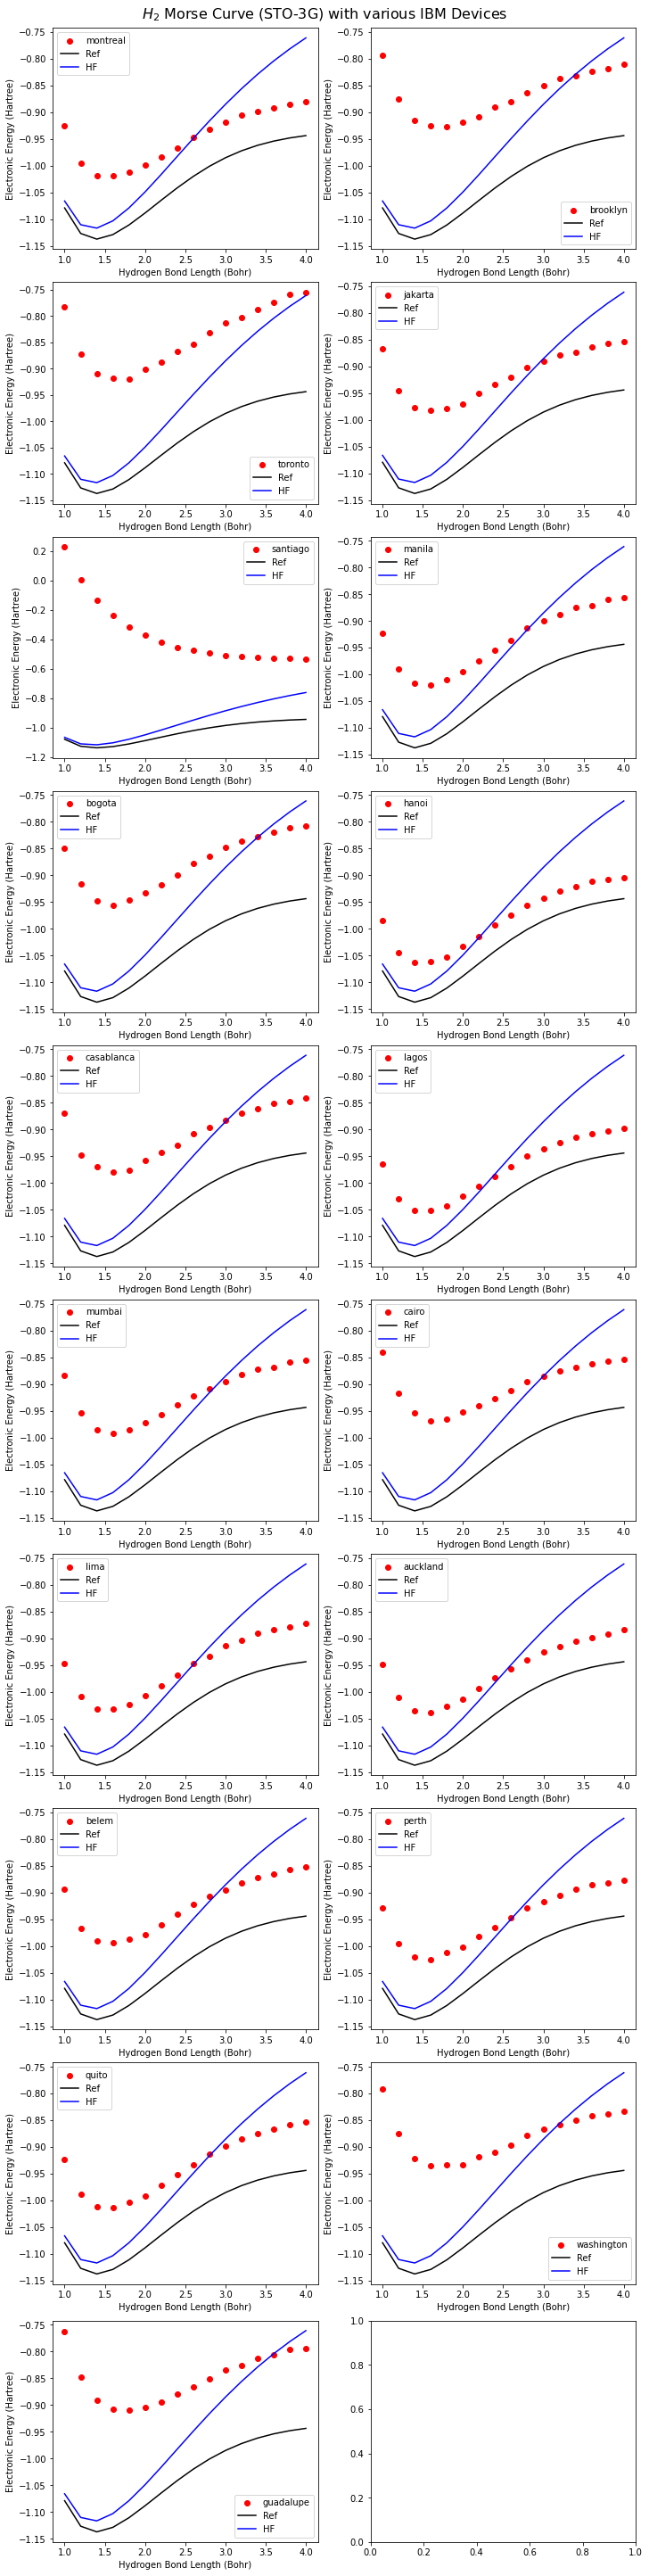

In [40]:
fig, ax = plt.subplots(10, 2, figsize=(10,40), constrained_layout=True)
fig.suptitle(r"$H_2$ Morse Curve (STO-3G) with various IBM Devices", fontsize=16)
for i in range(2):
    for j in range(10):
        if not((i==1) and (j==9)):
            ax[j][i].scatter(h2_opt_data['bond_length'], noisy_backend_noisy_morse[i*10+j], label=backend_list[i*10+j].split("_")[1], color='r')
            ax[j][i].plot(h2_opt_data['bond_length'], h2_opt_data['fci_ref_energy'], label='Ref', color='k')
            ax[j][i].plot(h2_opt_data['bond_length'], h2_opt_data['hf_ref_energy'], label='HF', color='b')
            ax[j][i].set_xlabel('Hydrogen Bond Length (Bohr)')
            ax[j][i].set_ylabel('Electronic Energy (Hartree)')
            ax[j][i].legend()


### IBM Noise Models of Quantum Devices

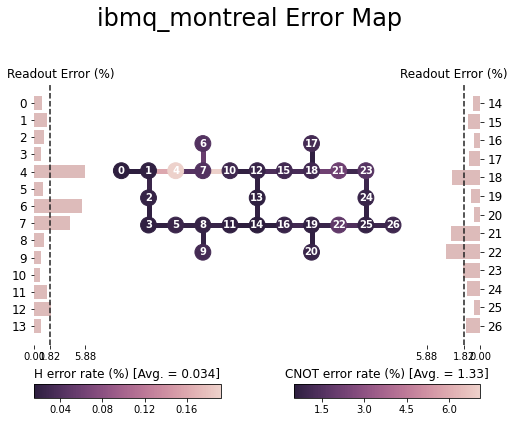

In [78]:
backend = provider.get_backend(backend_list[0])
qiskit.visualization.plot_error_map(backend, figsize=(8,7))

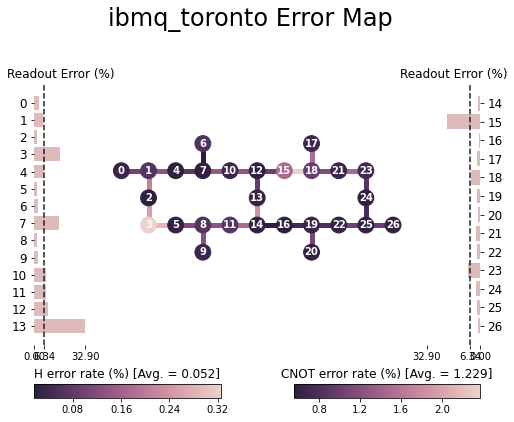

In [79]:
backend = provider.get_backend(backend_list[1])
qiskit.visualization.plot_error_map(backend, figsize=(8,7))

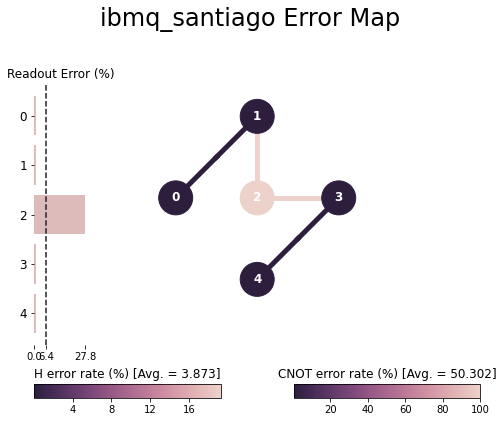

In [80]:
backend = provider.get_backend(backend_list[2])
qiskit.visualization.plot_error_map(backend, figsize=(8,7))

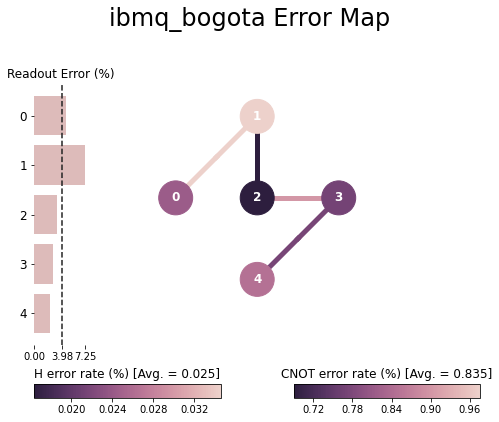

In [81]:
backend = provider.get_backend(backend_list[3])
qiskit.visualization.plot_error_map(backend, figsize=(8,7))

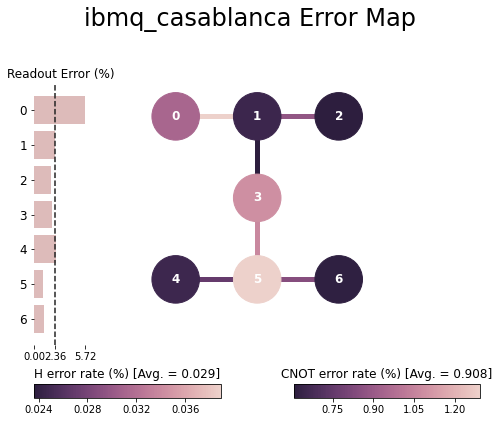

In [82]:
backend = provider.get_backend(backend_list[4])
qiskit.visualization.plot_error_map(backend, figsize=(8,7))

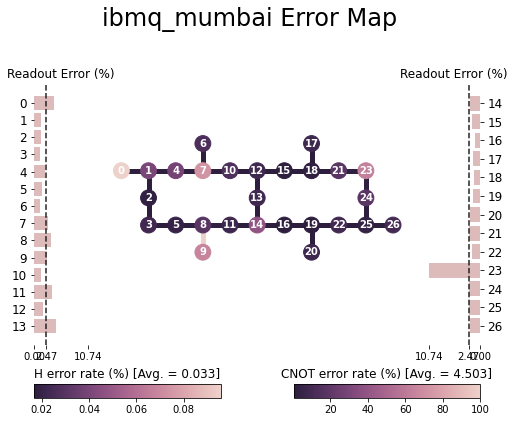

In [83]:
backend = provider.get_backend(backend_list[5])
qiskit.visualization.plot_error_map(backend, figsize=(8,7))

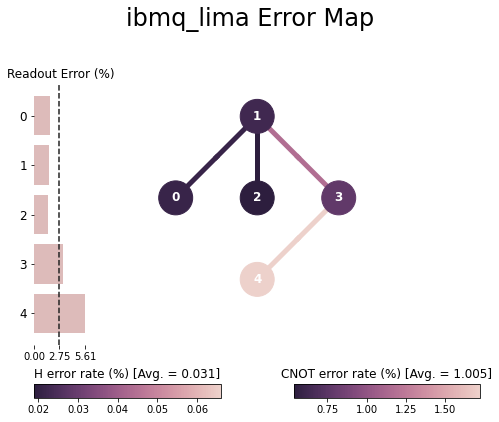

In [84]:
backend = provider.get_backend(backend_list[6])
qiskit.visualization.plot_error_map(backend, figsize=(8,7))

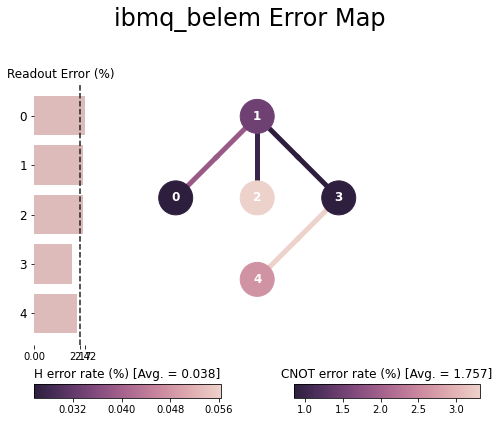

In [85]:
backend = provider.get_backend(backend_list[7])
qiskit.visualization.plot_error_map(backend, figsize=(8,7))

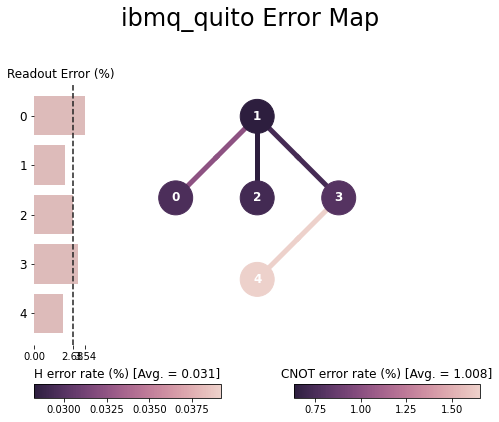

In [86]:
backend = provider.get_backend(backend_list[8])
qiskit.visualization.plot_error_map(backend, figsize=(8,7))

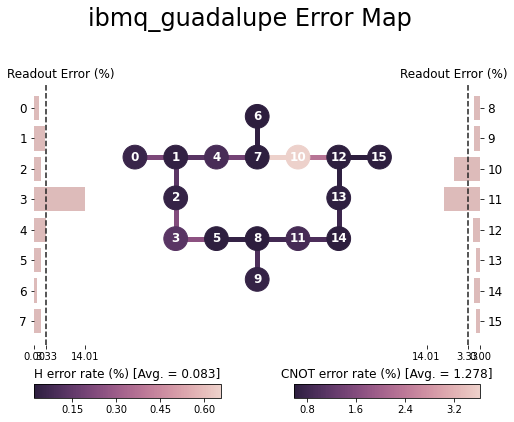

In [87]:
backend = provider.get_backend(backend_list[9])
qiskit.visualization.plot_error_map(backend, figsize=(8,7))

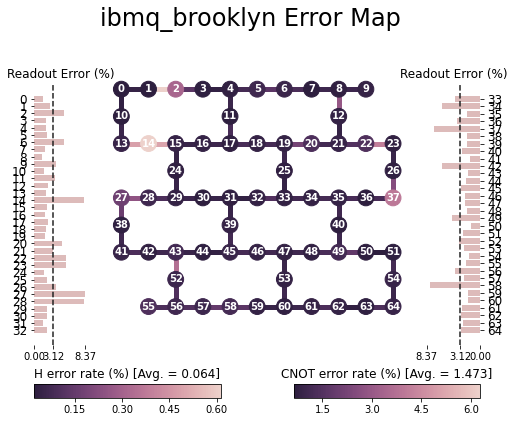

In [88]:
backend = provider.get_backend(backend_list[10])
qiskit.visualization.plot_error_map(backend, figsize=(8,7))

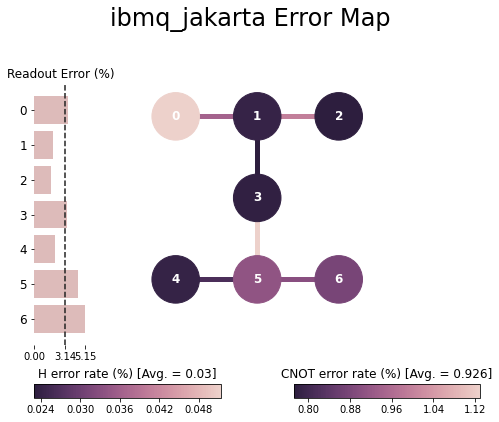

In [89]:
backend = provider.get_backend(backend_list[11])
qiskit.visualization.plot_error_map(backend, figsize=(8,7))

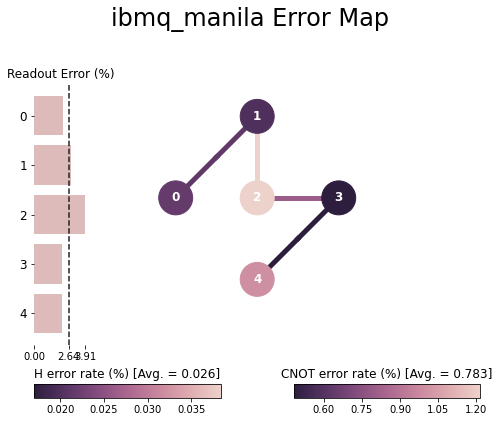

In [90]:
backend = provider.get_backend(backend_list[12])
qiskit.visualization.plot_error_map(backend, figsize=(8,7))

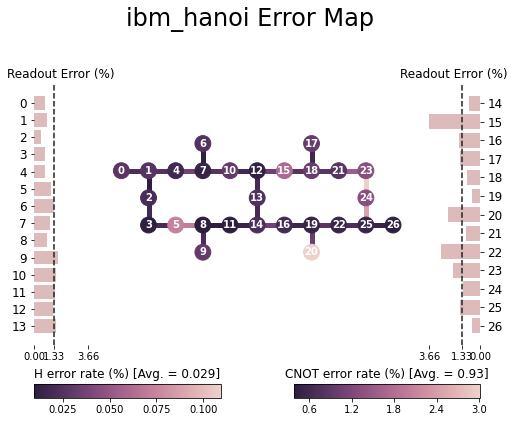

In [91]:
backend = provider.get_backend(backend_list[13])
qiskit.visualization.plot_error_map(backend, figsize=(8,7))

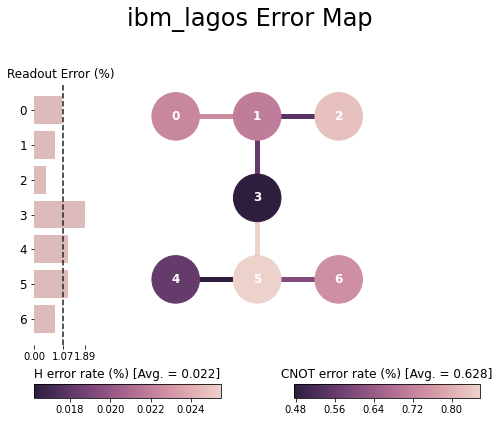

In [92]:
backend = provider.get_backend(backend_list[14])
qiskit.visualization.plot_error_map(backend, figsize=(8,7))

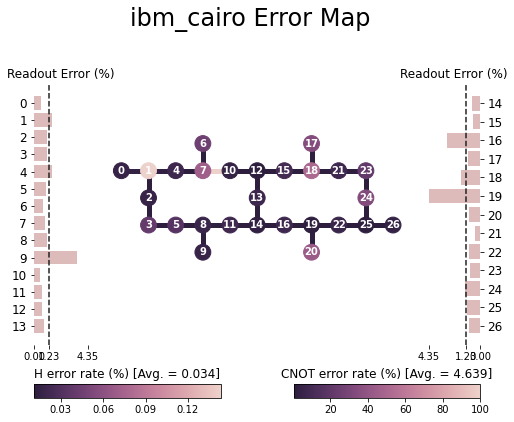

In [93]:
backend = provider.get_backend(backend_list[15])
qiskit.visualization.plot_error_map(backend, figsize=(8,7))

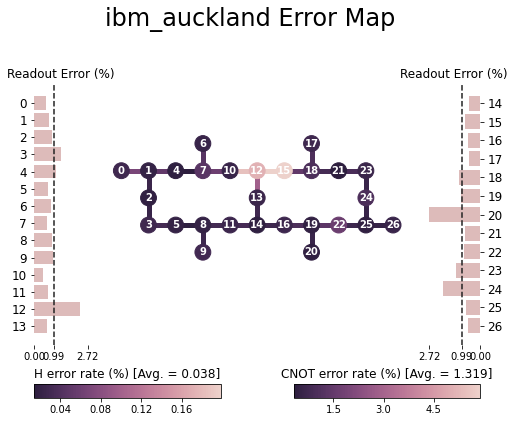

In [94]:
backend = provider.get_backend(backend_list[16])
qiskit.visualization.plot_error_map(backend, figsize=(8,7))

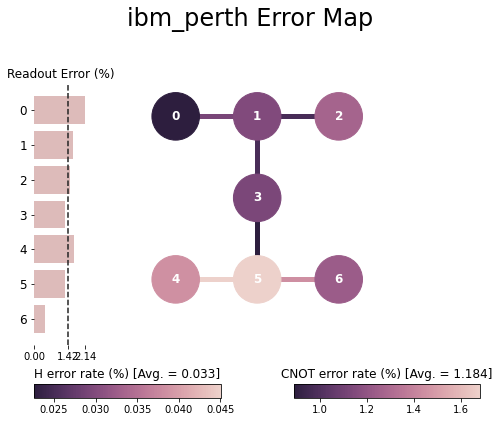

In [95]:
backend = provider.get_backend(backend_list[17])
qiskit.visualization.plot_error_map(backend, figsize=(8,7))

UnboundLocalError: local variable 'grid_data' referenced before assignment

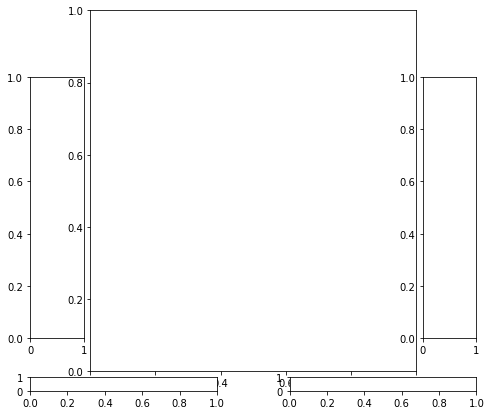

In [96]:
# This was supposed to be ibm_washington device
backend = provider.get_backend(backend_list[18])
qiskit.visualization.plot_error_map(backend, figsize=(8,7))